In [1]:
#This project has been worked in conjunction with the guidance found in the 
#Recording and Coding Guide for the Structure Inventory and Appraisal of the Nations Bridges on the FHWA website
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geocoder as geo
current_year = 2017

## Import and clean data

In [2]:
filedata = pd.read_csv('GA17.txt')
#drop all culverts from the dataset, we only want to analyze bridges
data = filedata.loc[filedata['CULVERT_COND_062']=='N']
num_bridges, num_columns = data.shape

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1,5,31,75,98) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def checkdf(df,columnlist):
    for column in column_list:
        if data[column].isnull().sum() > 0:
            print('Null values in',column,':',data[column].isnull().sum())
#Add age column for prediction
data['AGE'] = current_year - data['YEAR_BUILT_027']
#Collect columns of interest
column_list = ['LAT_016','LONG_017','YEAR_BUILT_027','AGE','STRUCTURE_LEN_MT_049','DESIGN_LOAD_031','ROADWAY_WIDTH_MT_051','ADT_029','YEAR_ADT_030','PERCENT_ADT_TRUCK_109','DEGREES_SKEW_034','HORR_CLR_MT_047','DECK_COND_058','SUPERSTRUCTURE_COND_059','SUBSTRUCTURE_COND_060','SUFFICIENCY_RATING']
#Convert all columns to numeric values
for column in column_list:
    data[column] = pd.to_numeric(data[column],errors='coerce')
checkdf(data,column_list)
#The last 4 columns are the variables to be predicted
feature_list = column_list[:-4]
df_features = data[feature_list]
print('')
print('Number of Bridges in Georgia (2017):',num_bridges)
print('Number of Dataset Columns:',num_columns)
print('Number of Features:',len(feature_list))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Null values in DESIGN_LOAD_031 : 4
Null values in PERCENT_ADT_TRUCK_109 : 30
Null values in DECK_COND_058 : 1
Null values in SUPERSTRUCTURE_COND_059 : 4

Number of Bridges in Georgia (2017): 9198
Number of Dataset Columns: 137
Number of Features: 12


Interestingly, the GDOT website says that there are 14,750 bridges in Georgia as of 2018. There definition must include culverts to some extent.

We have excluded bridges built before ASTM standards were in place, to normalize the data, because
bridges built before then would have had inconsistent standards for material acceptance in the bridge.
ASTM was officially founded in 1898, so if we choose a cutoff of 1900 to allow for adoption of the standard.

In [4]:
#Limit dataset to bridges built on or after 1900
data = data[data['YEAR_BUILT_027']>1900]
#Limit dataset further to bridges under 400 ft long
data = data[data['STRUCTURE_LEN_MT_049']<=400]
#Drop NA values
data = data.dropna(axis=0,subset=['OPERATING_RATING_064','PERCENT_ADT_TRUCK_109','INVENTORY_RATING_066','SUPERSTRUCTURE_COND_059','DESIGN_LOAD_031','DECK_COND_058'])
#Check dataset again for null values
checkdf(data,column_list)
print('Cleaned dataset # bridges:',data.shape[0])

Cleaned dataset # bridges: 9030


## Visualize Data

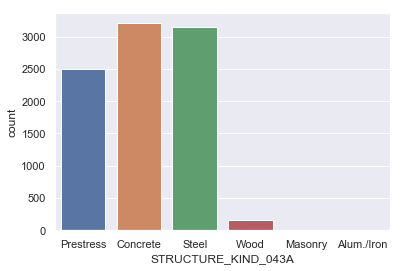

In [5]:
#Convert Bridge Type code to string based on FHWA manual
codedict = {1:'Concrete',2:'Concrete',3:'Steel',4:'Steel',5:'Prestress',6:'Prestress',7:'Wood',8:'Masonry',9:'Alum./Iron'}
data['STRUCTURE_KIND_043A'] = data['STRUCTURE_KIND_043A'].map(codedict)
type_count = pd.DataFrame(data.groupby('STRUCTURE_KIND_043A').size(),columns=['Count']).sort_values(by='Count',ascending=True)
sns.set(style="darkgrid")
sns.countplot(x='STRUCTURE_KIND_043A',data=data)
plt.show()

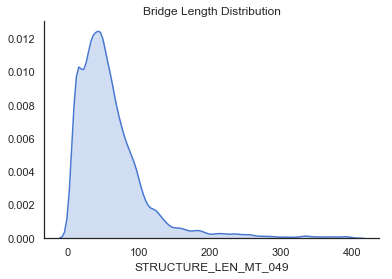

In [20]:
sns.distplot(data['STRUCTURE_LEN_MT_049'],hist=False,kde_kws={"shade": True})
plt.title('Bridge Length Distribution')
sns.set_style(style='whitegrid')
sns.despine(right=True)
plt.show()

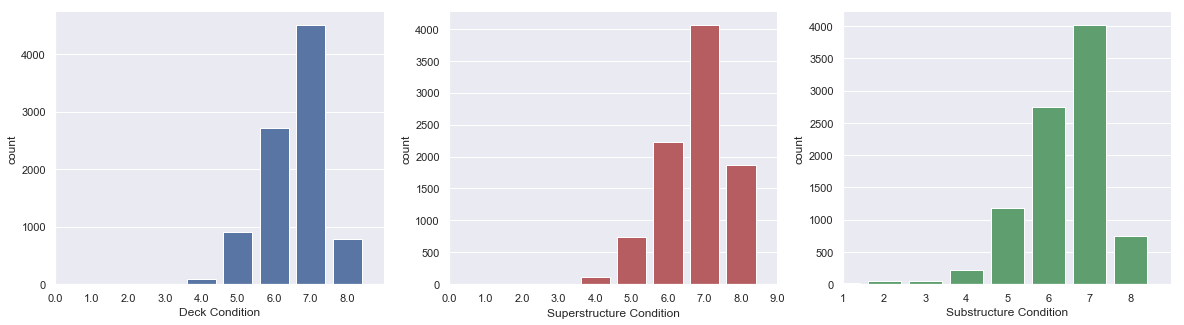

In [22]:
fig, axes = plt.subplots(ncols=3, nrows=1,figsize=(20,5))
#cat = ['0','1','2','3','4','5','6','7','8','9']
sns.despine(right=True)
# Plot a simple histogram with binsize determined automatically
sns.countplot(data=data,x='DECK_COND_058', color="b", ax=axes[0])
sns.countplot(data=data,x='SUPERSTRUCTURE_COND_059', color="r", ax=axes[1])
sns.countplot(data=data,x='SUBSTRUCTURE_COND_060', color='g', ax=axes[2])
sns.set(style="darkgrid")
axes[0].set_xlim(0,data['DECK_COND_058'].max()+1)
axes[1].set_xlim(0,data['SUPERSTRUCTURE_COND_059'].max())
axes[2].set_xlim(0,data['SUBSTRUCTURE_COND_060'].max())
axes[0].set_xlabel('Deck Condition')
axes[1].set_xlabel('Superstructure Condition')
axes[2].set_xlabel('Substructure Condition')
plt.show()

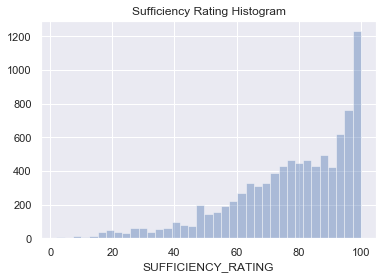

In [8]:
sns.distplot(data['SUFFICIENCY_RATING'],kde=False)
plt.title('Sufficiency Rating Histogram')
sns.set(style="white", palette="muted", color_codes=True)
plt.show()

In [9]:
below60 = data[data['SUFFICIENCY_RATING'] <= 50].shape[0] / data.shape[0] *100
below60

10.598006644518271

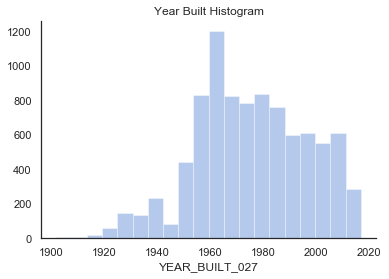

In [10]:
sns.distplot(data['YEAR_BUILT_027'],kde=False,bins=20)
plt.title('Year Built Histogram')
sns.set(style="white", palette="muted", color_codes=True)
sns.despine(right=True)
plt.show()

Looks like there was a spike of bridges built in the 1960s. This corresponds to passing of the Federal-Aid Highway Act of 1956 by President Eisenhower
https://www.fhwa.dot.gov/infrastructure/50interstate.cfm

145 years old! Let's all agree to never drive over that bridge in the future.

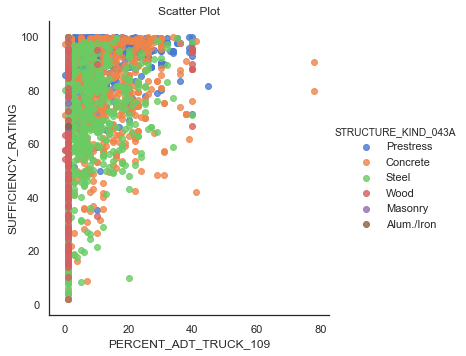

In [11]:
sns.lmplot(x='PERCENT_ADT_TRUCK_109',y='SUFFICIENCY_RATING',data=data,hue='STRUCTURE_KIND_043A',fit_reg=False)
plt.title('Scatter Plot')
plt.show()

## Find Correlations between features and columns we want to predict

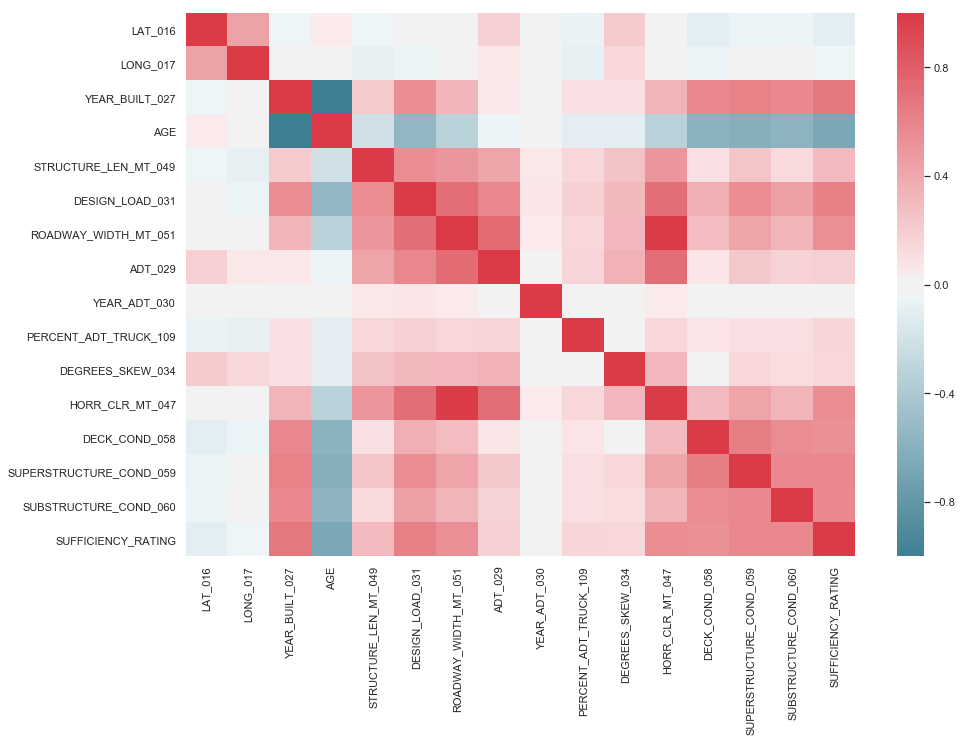

In [12]:
#Use spearman since some relationships may not be linear
heat = data[column_list].corr('spearman')
fig, ax = plt.subplots(figsize=(15, 10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(heat, cmap=colormap, annot=False, fmt=".2f")
plt.show()

In [13]:
correlation = heat.stack().reset_index()
correlation.columns = ['Feature 1','Feature 2','Spearman Corr.']
droprows = correlation[correlation['Spearman Corr.'].abs()==1]
correlation = correlation.drop(labels = droprows.index)
correlation.sort_values(by='Spearman Corr.',ascending=False)

Feature 1                Feature 2  Spearman Corr.
107     ROADWAY_WIDTH_MT_051          HORR_CLR_MT_047        0.988255
182          HORR_CLR_MT_047     ROADWAY_WIDTH_MT_051        0.988255
118                  ADT_029     ROADWAY_WIDTH_MT_051        0.730146
103     ROADWAY_WIDTH_MT_051                  ADT_029        0.730146
123                  ADT_029          HORR_CLR_MT_047        0.719254
183          HORR_CLR_MT_047                  ADT_029        0.719254
86           DESIGN_LOAD_031     ROADWAY_WIDTH_MT_051        0.712461
101     ROADWAY_WIDTH_MT_051          DESIGN_LOAD_031        0.712461
91           DESIGN_LOAD_031          HORR_CLR_MT_047        0.711572
181          HORR_CLR_MT_047          DESIGN_LOAD_031        0.711572
242       SUFFICIENCY_RATING           YEAR_BUILT_027        0.665420
47            YEAR_BUILT_027       SUFFICIENCY_RATING        0.665420
205            DECK_COND_058  SUPERSTRUCTURE_COND_059        0.625384
220  SUPERSTRUCTURE_COND_059            DECK_COND_058        0.625384
245       SUFFICIENCY_RATING          DESIGN_LOAD_031        0.615293
95           DESIGN_LOAD_031       SUFFICIENCY_RATING        0.615293
210  SUPERSTRUCTURE_COND_059           YEAR_BUILT_027        0.604990
45            YEAR_BUILT_027  SUPERSTRUCTURE_COND_059        0.604990
44            YEAR_BUILT_027            DECK_COND_058        0.584808
194            DECK_COND_058           YEAR_BUILT_027        0.584808
87           DESIGN_LOAD_031                  ADT_029        0.582105
117                  ADT_029          DESIGN_LOAD_031        0.582105
223  SUPERSTRUCTURE_COND_059       SUFFICIENCY_RATING        0.579656
253       SUFFICIENCY_RATING  SUPERSTRUCTURE_COND_059        0.579656
46            YEAR_BUILT_027    SUBSTRUCTURE_COND_060        0.577356
226    SUBSTRUCTURE_COND_060           YEAR_BUILT_027        0.577356
237    SUBSTRUCTURE_COND_060  SUPERSTRUCTURE_COND_059        0.576894
222  SUPERSTRUCTURE_COND_059    SUBSTRUCTURE_COND_060        0.576894
254       SUFFICIENCY_RATING    SUBSTRUCTURE_COND_060        0.576389
239    SUBSTRUCTURE_COND_060       SUFFICIENCY_RATING        0.576389
..                       ...                      ...             ...
9                    LAT_016    PERCENT_ADT_TRUCK_109       -0.068563
144    PERCENT_ADT_TRUCK_109                  LAT_016       -0.068563
20                  LONG_017     STRUCTURE_LEN_MT_049       -0.080917
65      STRUCTURE_LEN_MT_049                 LONG_017       -0.080917
25                  LONG_017    PERCENT_ADT_TRUCK_109       -0.081969
145    PERCENT_ADT_TRUCK_109                 LONG_017       -0.081969
163         DEGREES_SKEW_034                      AGE       -0.096026
58                       AGE         DEGREES_SKEW_034       -0.096026
147    PERCENT_ADT_TRUCK_109                      AGE       -0.098731
57                       AGE    PERCENT_ADT_TRUCK_109       -0.098731
15                   LAT_016       SUFFICIENCY_RATING       -0.102897
240       SUFFICIENCY_RATING                  LAT_016       -0.102897
192            DECK_COND_058                  LAT_016       -0.105425
12                   LAT_016            DECK_COND_058       -0.105425
67      STRUCTURE_LEN_MT_049                      AGE       -0.212386
52                       AGE     STRUCTURE_LEN_MT_049       -0.212386
54                       AGE     ROADWAY_WIDTH_MT_051       -0.325740
99      ROADWAY_WIDTH_MT_051                      AGE       -0.325740
179          HORR_CLR_MT_047                      AGE       -0.334420
59                       AGE          HORR_CLR_MT_047       -0.334420
83           DESIGN_LOAD_031                      AGE       -0.543614
53                       AGE          DESIGN_LOAD_031       -0.543614
227    SUBSTRUCTURE_COND_060                      AGE       -0.577356
62                       AGE    SUBSTRUCTURE_COND_060       -0.577356
60                       AGE            DECK_COND_058       -0.584808
195            DECK_COND_058 

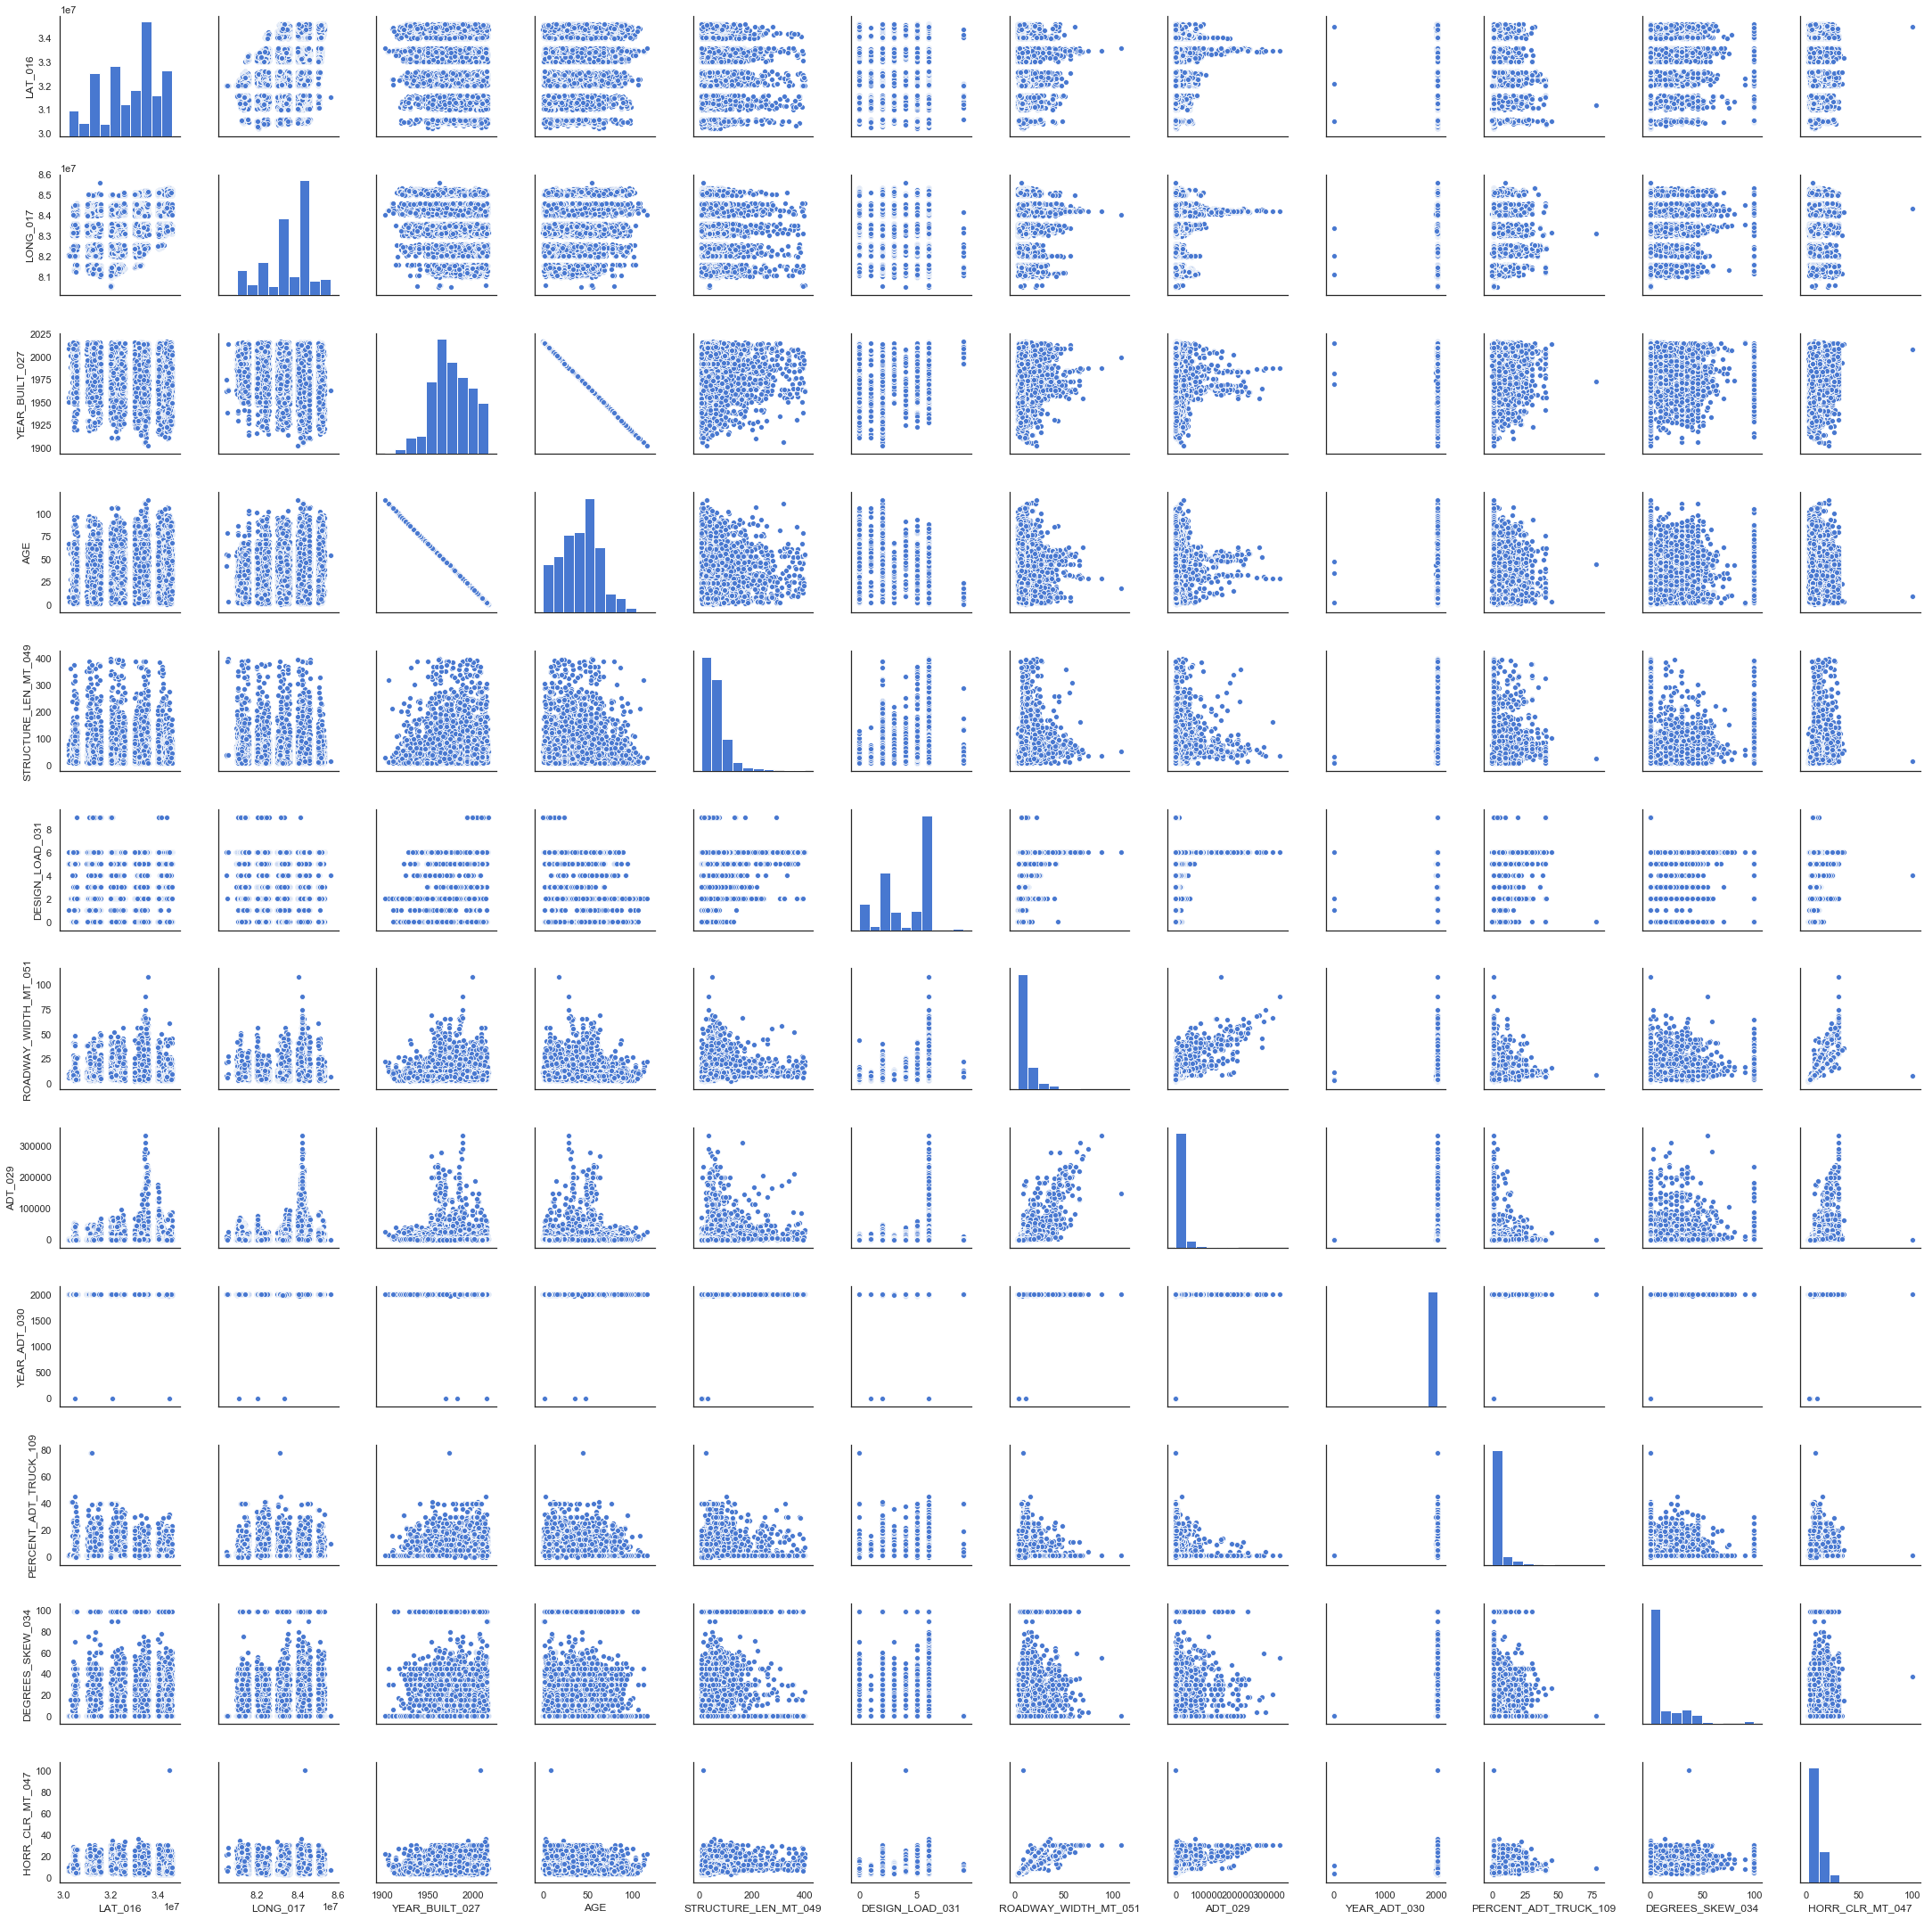

In [14]:
sns.pairplot(data[feature_list])
plt.show()

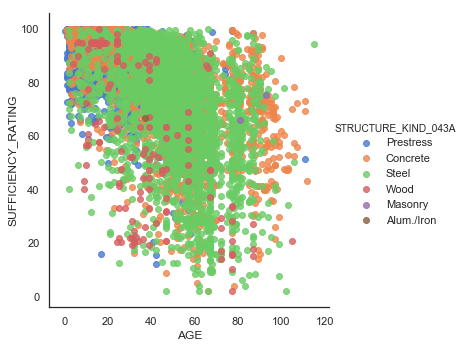

In [15]:
age_data = data.groupby('AGE').mean()
age_data = age_data.reset_index()
sns.lmplot(x='AGE',y='SUFFICIENCY_RATING',data=data,hue='STRUCTURE_KIND_043A',fit_reg=False)
plt.show()

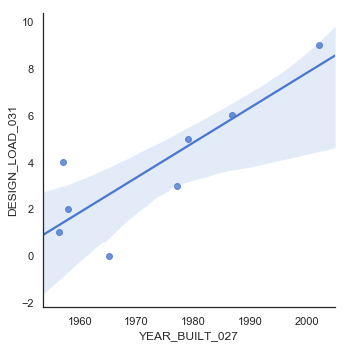

In [17]:
load_data = data.groupby('DESIGN_LOAD_031').mean()
load_data = load_data.reset_index()
sns.lmplot(x='YEAR_BUILT_027',y='DESIGN_LOAD_031',data=load_data)
plt.show()

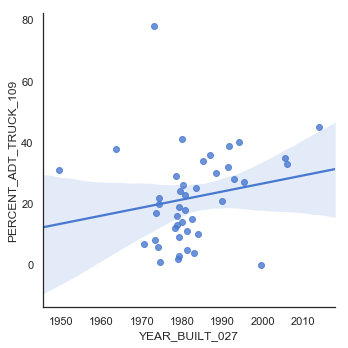

In [18]:
truck_data = data.groupby('PERCENT_ADT_TRUCK_109').mean()
truck_data = truck_data.reset_index()
sns.lmplot(x='YEAR_BUILT_027',y='PERCENT_ADT_TRUCK_109',data=truck_data)
plt.show()